In [ ]:
# Import Packages

In [ ]:
import numpy as np
import os
from PIL import Image, ImageChops, ImageEnhance

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback

from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
# Flattening of the DCT Coefficients into a 1D-Vector

In [1]:
for folders, subfolders, files in os.walk('../DCT_Data'):      # Path of the DCT root folder
   for file in files:
     file_path = os.path.join(folders, file)
     try:
        data = np.load(file_path)
        data = data.flatten()
        np.save(file_path, data)
     except Exception as e:
         print(f"Error loading or saving file {file_path}: {e}")

In [ ]:
# Function to load pre-processed ELA/Noise Residual SRM images and DCT coefficients along with the lables
# Apart from VidTIMIT-DFTIMIT dataset, for training and evaluation
# only 80,000 real and fake ELA/SRM images and DCT coefficients are considered 

In [4]:
def preprocess(path1, path2, label):
    SRM_images = []
    DCT_images = []
    labels = []

    prefix = 'Real' if label == 0 else 'Fake'
    srm_root = os.path.join(path1, prefix)
    dct_root = os.path.join(path2, prefix)

    folders = sorted(os.listdir(srm_root))
    cnt_folders = 0
    total_images = 0
    for folder in folders:
        srm_folder_path = os.path.join(srm_root, folder)
        dct_folder_path = os.path.join(dct_root, folder)

        if not os.path.exists(dct_folder_path):
            continue

        srm_files = sorted(os.listdir(srm_folder_path))
        dct_files = sorted(os.listdir(dct_folder_path))
        cnt_images = 0
        for srm_file, dct_file in zip(srm_files, dct_files):
            srm_path = os.path.join(srm_folder_path, srm_file)
            dct_path = os.path.join(dct_folder_path, dct_file)

            # Print the paired image IDs
            # print(f"Processing pair - ELA: {ela_file}, SRM: {srm_file}")

            try:
                srm_img = Image.open(srm_path).convert('RGB').resize((128, 128))
                # dct_img = Image.open(dct_path).convert('RGB').resize((128, 128))
                dct_img = np.load(dct_path)
                SRM_images.append(np.array(srm_img))
                DCT_images.append(dct_img)
                labels.append(label)
                cnt_images += 1
                total_images += 1
                if total_images >= 80000:
                    break

            except Exception as e:
                print(f"Skipping image pair ({srm_file}, {dct_file}): {e}")
        cnt_folders += 1
        if total_images >= 80000:
            print(total_images)
            break
    print(f'No of Folders taken: {cnt_folders}')

    return SRM_images, DCT_images, labels

In [5]:
# Paths to your dataset folders
path1 = '../ELA_Data'         # Path of the ELA/SRM root folder of a Dataset
path2 = '../DCT_Data'         # Path of the DCT coefficients of a Dataset

# Load and preprocess both classes
srm_real, dct_real, labels_real = preprocess(path1, path2, label=0)
srm_fake, dct_fake, labels_fake = preprocess(path1, path2, label=1)

# Merge data without using np.concatenate (faster and lower memory)
SRM_total = np.array(srm_real + srm_fake, dtype=np.float32) / 255.0
DCT_total = np.array(dct_real + dct_fake, dtype=np.float32) / 255.0
labels_total = np.array(labels_real + labels_fake)

print(f"Loaded {len(labels_total)} samples.")
print(f"SRM shape: {SRM_total.shape}, dtype: {SRM_total.dtype}")
print(f"DCT shape: {DCT_total.shape}, dtype: {DCT_total.dtype}")

80000
No of Folders taken: 230
80000
No of Folders taken: 215
Loaded 160000 samples.
SRM shape: (160000, 128, 128, 3), dtype: float32
DCT shape: (160000, 256), dtype: float32


In [ ]:
# Splitting of Dataset into 80-20 ratio for training and evaluation

In [7]:
SRM_train, SRM_test, DCT_train, DCT_test, y_train, y_test = train_test_split(
        SRM_total, DCT_total, labels_total, test_size=0.2, random_state=42)
print(f'SRM train shape is: {SRM_train.shape}')
print(f'DCT train shape is: {DCT_train.shape}')

SRM train shape is: (128000, 128, 128, 3)
DCT train shape is: (128000, 256)


In [ ]:
# Creation of Dual-Branch CNNs for the experiments
# The architecture is kept shallow in nature

In [9]:
def build_model():
  input_srm = layers.Input(shape=(128,128,3), name='SRM_Input')
  x_srm = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_srm)
  x_srm = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x_srm)
  x_srm = layers.MaxPooling2D((2, 2))(x_srm)
  x_srm = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x_srm)
  x_srm = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x_srm)
  x_srm = layers.MaxPooling2D((2, 2))(x_srm)


  input_dct = layers.Input(shape=(256,1) , name = 'DCT_Input')
  x_dct = layers.Conv1D(100,3,activation='relu',padding='same')(input_dct)
  x_dct = layers.Conv1D(100,3,activation='relu',padding='same')(x_dct)
  x_dct = layers.MaxPooling1D(2)(x_dct)
  x_dct = layers.Conv1D(100,3,activation='relu',padding='same')(x_dct)
  x_dct = layers.Conv1D(100,3,activation='relu',padding='same')(x_dct)
  x_dct = layers.MaxPooling1D(2)(x_dct)

  flatten_srm = layers.Flatten()(x_srm)
  flatten_dct = layers.Flatten()(x_dct)
  print(flatten_srm.shape)
  print(x_dct.shape)
  combined = layers.Concatenate()([flatten_srm,flatten_dct])
  combined = layers.Dense(256, activation='relu')(combined)
  combined = layers.Dropout(0.5)(combined)

  output = layers.Dense(1, activation='sigmoid')(combined)
  model = models.Model(inputs=[input_srm, input_dct], outputs=output)
  return model

model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
model.summary()

2025-08-07 11:52:15.446772: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2025-08-07 11:52:15.498148: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2025-08-07 11:52:15.499050: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 1 with properties: 
pciBusID: 0000:d8:00.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2025-08-07 11:52:15.499245: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-08-07 11:52:15.500704: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-08-07 11:52:15.5

(None, 32768)
(None, 64, 100)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
SRM_Input (InputLayer)          [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
DCT_Input (InputLayer)          [(None, 256, 1)]     0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         SRM_Input[0][0]                  
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 256, 100)     400         DCT_Input[0][0]                  
________________________________________________________________

In [ ]:
# Custom Callback used to deal with overfitting 
# Saves only those checkpoints where difference between train accuracy and val accuracy is minimum
# Also saves the checkpoints where the val accuracy is better than the previous stored val accuracy

In [10]:
class MinDiffCheckpoint(Callback):
    def __init__(self, filepath, monitor='val_accuracy', prev_val = -10**9 ,min_delta=0.02):
        super(MinDiffCheckpoint, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.min_delta = min_delta     # Minimum acceptable difference
        self.best_diff = np.inf        # Initialize with infinity
        self.best_weights = None
        self.prev_val = prev_val
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        
        # Get current metrics
        val_acc = logs.get('val_accuracy')
        train_acc = logs.get('accuracy')
        
        if val_acc is None or train_acc is None:
            return
            
        # Calculate absolute difference
        current_diff = abs(train_acc - val_acc)
        
        # Check if difference is below threshold and better than previous best
        if current_diff < self.min_delta or current_diff < self.best_diff:
            
            # Save the model
            if self.prev_val < val_acc:
                self.prev_val=val_acc
                self.model.save_weights(self.filepath, overwrite=True)
                print(f"\nDifference improved from {self.best_diff:.4f} to {current_diff:.4f}")
                self.best_diff = current_diff
                self.best_weights = self.model.get_weights()
                print(f"Model saved with train-val difference: {current_diff:.4f}")

    def on_train_end(self, logs=None):
        # Restore the best weights found
        if self.best_weights is not None:
            self.model.set_weights(self.best_weights)
            print(f"\nTraining complete. Restoring weights with best difference: {self.best_diff:.4f}")

In [11]:
checkpoint = MinDiffCheckpoint(
    filepath='checkPoint_CDF_ELA_DCT.keras',       # Name of saved checkpoint
    monitor='val_accuracy',
    min_delta=0.1
)

In [ ]:
# Training of the proposed model

In [12]:
history = model.fit(
        [SRM_train, DCT_train],
        y_train,
        epochs=20,
        batch_size=32,
        validation_data = ([SRM_test, DCT_test], y_test),
        callbacks = [checkpoint]
    )

2025-08-07 11:52:16.558355: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 25165824000 exceeds 10% of free system memory.


Epoch 1/20


2025-08-07 11:52:29.275165: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-08-07 11:52:29.962845: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


3999/4000 [============================>.] - ETA: 0s - loss: 0.1844 - accuracy: 0.9250
Difference improved from inf to 0.0494
Model saved with train-val difference: 0.0494
4000/4000 [==============================] - 142s 35ms/step - loss: 0.1844 - accuracy: 0.9250 - val_loss: 0.0758 - val_accuracy: 0.9744
Epoch 2/20
3999/4000 [============================>.] - ETA: 0s - loss: 0.0659 - accuracy: 0.9766
Difference improved from 0.0494 to 0.0103
Model saved with train-val difference: 0.0103
4000/4000 [==============================] - 144s 36ms/step - loss: 0.0659 - accuracy: 0.9766 - val_loss: 0.0377 - val_accuracy: 0.9870
Epoch 3/20
3999/4000 [============================>.] - ETA: 0s - loss: 0.0402 - accuracy: 0.9858
Difference improved from 0.0103 to 0.0052
Model saved with train-val difference: 0.0052
4000/4000 [==============================] - 145s 36ms/step - loss: 0.0402 - accuracy: 0.9858 - val_loss: 0.0281 - val_accuracy: 0.9911
Epoch 4/20
3999/4000 [==========================

In [13]:
model.save('DFDC_ELA_DCT.keras')       # Saving of the model with best metrics

In [ ]:
# Evaluation of the proposed model

In [14]:
model = tf.keras.models.load_model('DFDC_ELA_DCT.keras')
y_pred_prob = model.predict([SRM_test, DCT_test])
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

Accuracy: 0.99665625


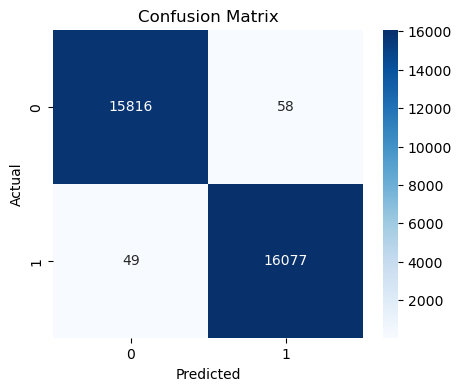

In [16]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print("Accuracy:", acc)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


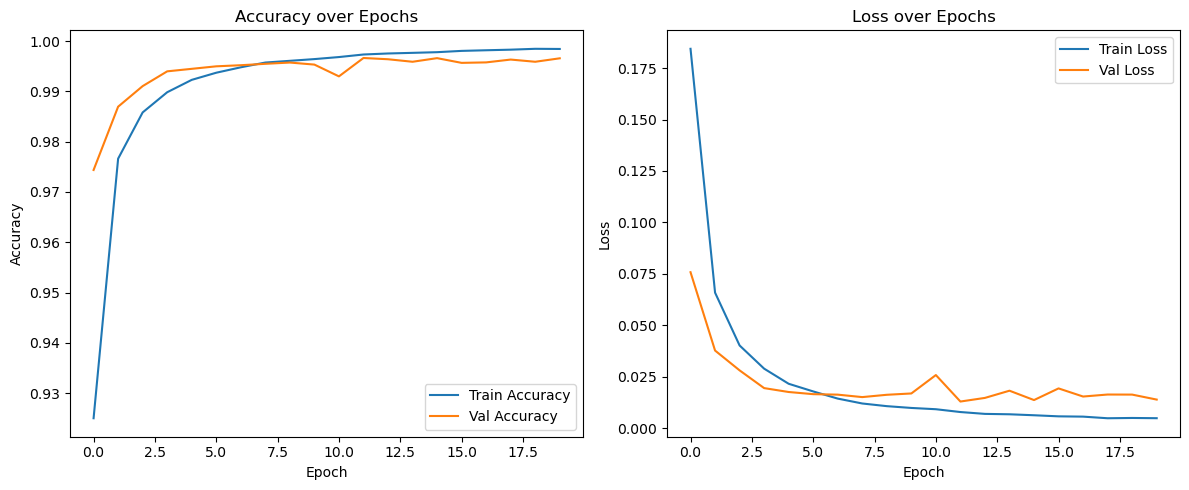

In [17]:
# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

0.9998522564625921


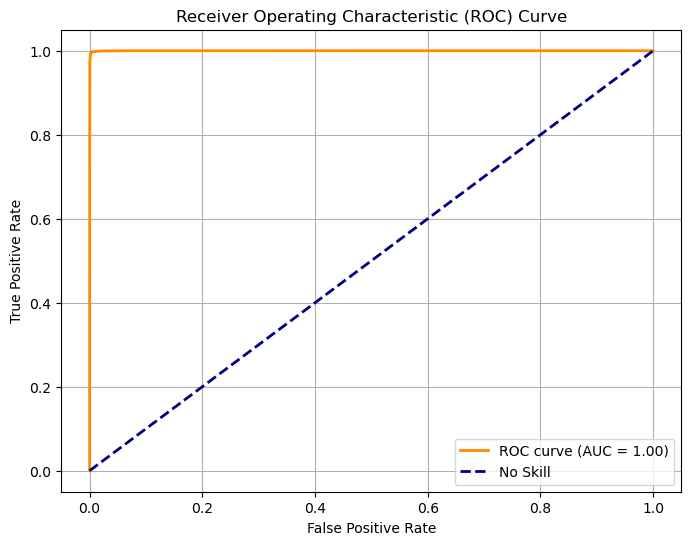

In [18]:
# AUC-ROC Curve
y_probs = model.predict([SRM_test, DCT_test])

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
print(roc_auc_score(y_test, y_probs))
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()